In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb

df = pd.read_parquet("ny_ride_fair_optimization/nik_folder/Resources/model_df.parquet")

# show all columns
pd.set_option('display.max_columns', None)
df


,"('second_of_day',)","('day_of_year',)","('weekend',)","('holiday',)","('morning_rush',)","('evening rush',)","('prcp',)","('temp',)","('PUx',)","('PUy',)","('DOx',)","('DOy',)","('distance',)","('duration(sec)',)","('fare',)","('tolls',)","('airport',)","('congestion',)","('total',)","('class',)","('PU_Bronx',)","('PU_Brooklyn',)","('PU_Manhattan',)","('PU_Queens',)","('PU_Staten Island',)","('DO_Bronx',)","('DO_Brooklyn',)","('DO_Manhattan',)","('DO_Queens',)","('DO_Staten Island',)"
0,5,1,False,1,0,0,0.0,42.80,-8.213879e+06,4.960411e+06,-8.232220e+06,4.983524e+06,18.85,1599.0,70.00,6.94,0.0,0.0,95.88,0,False,False,False,True,False,False,False,True,False,False
1,9,1,False,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.00,0.0,0.0,14.59,1,True,False,False,False,False,True,False,False,False,False
2,33,1,False,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,2.02,474.0,20.62,0.00,0.0,0.0,20.62,2,False,False,False,True,False,False,True,False,False,False
3,38,1,False,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,2.47,459.0,23.20,0.00,0.0,0.0,23.20,2,False,False,False,True,False,False,False,False,True,False
4,42,1,False,1,0,0,0.0,42.80,-8.235990e+06,4.975327e+06,-8.235160e+06,4.976716e+06,1.06,335.0,7.90,0.00,0.0,2.5,15.48,0,False,False,True,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044442,85846,366,False,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06,2.48,534.0,14.38,0.00,0.0,0.0,14.38,2,True,False,False,False,False,True,False,False,False,False
6044443,85864,366,False,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06,1.58,488.0,15.01,0.00,0.0,0.0,15.01,2,False,True,False,False,False,False,True,False,False,False
6044444,85870,366,False,0,0,0,0.0,48.02,-8.236077e+06,4.972248e+06,-8.236077e+06,4.972248e+06,0.60,256.0,5.80,0.00,0.0,2.5,10.80,0,False,False,True,False,False,False,False,True,False,False
6044445,86042,366,False,0,0,0,0.0,48.02,-8.220615e+06,4.964609e+06,-8.224081e+06,4.965819e+06,1.36,266.0,8.92,0.00,0.0,0.0,8.92,1,False,False,False,True,False,False,True,False,False,False


In [39]:
# fix a few row issues

pd.set_option('display.max_columns', None)
df.columns = df.columns.str.replace(r"[()',]", "", regex=True).str.strip()
df = df.replace({True: 1, False: 0})

df.rename(columns={"fore": "fare"}, inplace=True)
df.rename(columns={"class": "service"}, inplace=True)
df

/var/folders/vt/jy8dcmxj29vfz95p7lls9h1m0000gn/T/ipykernel_1446/1778932464.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,service,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island
0,5,1,0,1,0,0,0.0,42.80,-8.213879e+06,4.960411e+06,-8.232220e+06,4.983524e+06,18.85,1599.0,70.00,6.94,0.0,0.0,95.88,0,0,0,0,1,0,0,0,1,0,0
1,9,1,0,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.00,0.0,0.0,14.59,1,1,0,0,0,0,1,0,0,0,0
2,33,1,0,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,2.02,474.0,20.62,0.00,0.0,0.0,20.62,2,0,0,0,1,0,0,1,0,0,0
3,38,1,0,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,2.47,459.0,23.20,0.00,0.0,0.0,23.20,2,0,0,0,1,0,0,0,0,1,0
4,42,1,0,1,0,0,0.0,42.80,-8.235990e+06,4.975327e+06,-8.235160e+06,4.976716e+06,1.06,335.0,7.90,0.00,0.0,2.5,15.48,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044442,85846,366,0,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06,2.48,534.0,14.38,0.00,0.0,0.0,14.38,2,1,0,0,0,0,1,0,0,0,0
6044443,85864,366,0,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06,1.58,488.0,15.01,0.00,0.0,0.0,15.01,2,0,1,0,0,0,0,1,0,0,0
6044444,85870,366,0,0,0,0,0.0,48.02,-8.236077e+06,4.972248e+06,-8.236077e+06,4.972248e+06,0.60,256.0,5.80,0.00,0.0,2.5,10.80,0,0,0,1,0,0,0,0,1,0,0
6044445,86042,366,0,0,0,0,0.0,48.02,-8.220615e+06,4.964609e+06,-8.224081e+06,4.965819e+06,1.36,266.0,8.92,0.00,0.0,0.0,8.92,1,0,0,0,1,0,0,1,0,0,0


In [40]:
# starting to develop the idea for the target

df["profit_per_hour"] = df["fare"] / (df["durationsec"] / 3600).round(2)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.loc[df["profit_per_hour"] > 1]

In [41]:
# remove outliers for more robust model

df["profit_per_hour"].std() * 3

397.9574200633954

In [42]:
df = df[df["profit_per_hour"] < 397.95]
df

,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,service,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,profit_per_hour
0,5,1,0,1,0,0,0.0,42.80,-8.213879e+06,4.960411e+06,-8.232220e+06,4.983524e+06,18.85,1599.0,70.00,6.94,0.0,0.0,95.88,0,0,0,0,1,0,0,0,1,0,0,159.090909
1,9,1,0,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.00,0.0,0.0,14.59,1,1,0,0,0,0,1,0,0,0,0,66.318182
2,33,1,0,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,2.02,474.0,20.62,0.00,0.0,0.0,20.62,2,0,0,0,1,0,0,1,0,0,0,158.615385
3,38,1,0,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,2.47,459.0,23.20,0.00,0.0,0.0,23.20,2,0,0,0,1,0,0,0,0,1,0,178.461538
4,42,1,0,1,0,0,0.0,42.80,-8.235990e+06,4.975327e+06,-8.235160e+06,4.976716e+06,1.06,335.0,7.90,0.00,0.0,2.5,15.48,0,0,0,1,0,0,0,0,1,0,0,87.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044442,85846,366,0,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06,2.48,534.0,14.38,0.00,0.0,0.0,14.38,2,1,0,0,0,0,1,0,0,0,0,95.866667
6044443,85864,366,0,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06,1.58,488.0,15.01,0.00,0.0,0.0,15.01,2,0,1,0,0,0,0,1,0,0,0,107.214286
6044444,85870,366,0,0,0,0,0.0,48.02,-8.236077e+06,4.972248e+06,-8.236077e+06,4.972248e+06,0.60,256.0,5.80,0.00,0.0,2.5,10.80,0,0,0,1,0,0,0,0,1,0,0,82.857143
6044445,86042,366,0,0,0,0,0.0,48.02,-8.220615e+06,4.964609e+06,-8.224081e+06,4.965819e+06,1.36,266.0,8.92,0.00,0.0,0.0,8.92,1,0,0,0,1,0,0,1,0,0,0,127.428571


In [43]:
# create clusters with coordinates and airport data (experimental feature)

pu_features = ["PUx", "PUy", "airport"]
do_features = ["DOx", "DOy", "airport"]

scaler_pu = StandardScaler()
pu_scaled = scaler_pu.fit_transform(df[pu_features])

scaler_do = StandardScaler()
do_scaled = scaler_do.fit_transform(df[do_features])


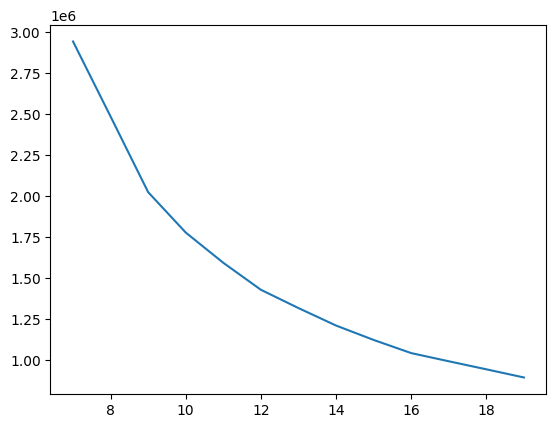

In [44]:
# find elbow for location and airport encoded clusters

inertia = []
K_range = range(7, 20) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pu_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia)
plt.show()

In [45]:
# SET K HERE

pu_k = 9
kmeans = KMeans(n_clusters=pu_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(pu_scaled)


/opt/anaconda3/envs/dev/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


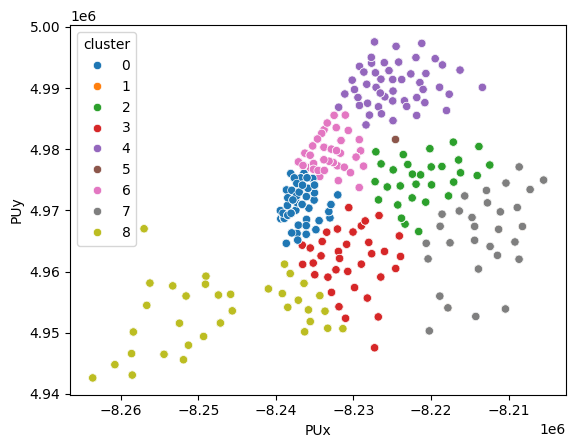

In [46]:
sns.scatterplot(x=df["PUx"], y=df["PUy"], hue=df["cluster"], palette="tab10")
plt.show()

In [47]:

df_taxi = df[(df["service"] == 0) & (df["fare"] > 0)]
df_uber = df[(df["service"] == 1) & (df["fare"] > 0)]
df_lyft = df[(df["service"] == 2) & (df["fare"] > 0)]


In [48]:
df_uber.head(20)

,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,service,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,profit_per_hour,cluster
1,9,1,0,1,0,0,0.0,42.8,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.0,0.0,0.00,14.59,1,1,0,0,0,0,1,0,0,0,0,66.318182,4
8,75,1,0,1,0,0,0.0,42.8,-8.221833e+06,4.988439e+06,-8.221833e+06,4.988439e+06,0.54,172.0,8.94,0.0,0.0,0.00,8.94,1,1,0,0,0,0,1,0,0,0,0,178.800000,4
13,162,1,0,1,0,0,0.0,42.8,-8.236580e+06,4.974117e+06,-8.232857e+06,4.980010e+06,4.19,1323.0,25.24,0.0,0.0,2.75,27.99,1,0,0,1,0,0,0,0,1,0,0,68.216216,0
19,202,1,0,1,0,0,0.0,42.8,-8.236394e+06,4.976052e+06,-8.236580e+06,4.974117e+06,2.80,2453.0,46.35,0.0,0.0,2.75,49.10,1,0,0,1,0,0,0,0,1,0,0,68.161765,0
27,257,1,0,1,0,0,0.0,42.8,-8.236601e+06,4.964303e+06,-8.227168e+06,4.992488e+06,17.92,2152.0,51.24,0.0,0.0,2.75,53.99,1,0,1,0,0,0,1,0,0,0,0,85.400000,3
29,264,1,0,1,0,0,0.0,42.8,-8.230737e+06,4.960015e+06,-8.237633e+06,4.975305e+06,13.10,3345.0,49.42,0.0,0.0,2.75,52.17,1,0,1,0,0,0,0,0,1,0,0,53.139785,3
31,268,1,0,1,0,0,0.0,42.8,-8.225418e+06,4.992844e+06,-8.221019e+06,4.989768e+06,6.87,1373.0,13.77,0.0,0.0,0.00,13.77,1,1,0,0,0,0,1,0,0,0,0,36.236842,4
33,281,1,0,1,0,0,0.0,42.8,-8.237813e+06,4.971700e+06,-8.239092e+06,4.969534e+06,1.63,436.0,19.93,0.0,0.0,2.75,22.68,1,0,0,1,0,0,0,0,1,0,0,166.083333,0
34,286,1,0,1,0,0,0.0,42.8,-8.226459e+06,4.991442e+06,-8.227081e+06,4.990103e+06,0.58,213.0,8.86,0.0,0.0,0.00,8.86,1,1,0,0,0,0,1,0,0,0,0,147.666667,4
37,312,1,0,1,0,0,0.0,42.8,-8.229257e+06,4.973729e+06,-8.226481e+06,4.959098e+06,18.31,2027.0,51.94,0.0,0.0,0.00,51.94,1,0,0,0,1,0,0,1,0,0,0,92.750000,6


In [49]:
# turn the clusters and service into booleans for training

df = pd.get_dummies(df, columns=["cluster"])
df = pd.get_dummies(df, columns=["service"])
df

,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,profit_per_hour,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,service_0,service_1,service_2
0,5,1,0,1,0,0,0.0,42.80,-8.213879e+06,4.960411e+06,-8.232220e+06,4.983524e+06,18.85,1599.0,70.00,6.94,0.0,0.0,95.88,0,0,0,1,0,0,0,1,0,0,159.090909,False,False,False,False,False,False,False,True,False,True,False,False
1,9,1,0,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.00,0.0,0.0,14.59,1,0,0,0,0,1,0,0,0,0,66.318182,False,False,False,False,True,False,False,False,False,False,True,False
2,33,1,0,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,2.02,474.0,20.62,0.00,0.0,0.0,20.62,0,0,0,1,0,0,1,0,0,0,158.615385,False,False,False,False,False,False,True,False,False,False,False,True
3,38,1,0,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,2.47,459.0,23.20,0.00,0.0,0.0,23.20,0,0,0,1,0,0,0,0,1,0,178.461538,False,False,True,False,False,False,False,False,False,False,False,True
4,42,1,0,1,0,0,0.0,42.80,-8.235990e+06,4.975327e+06,-8.235160e+06,4.976716e+06,1.06,335.0,7.90,0.00,0.0,2.5,15.48,0,0,1,0,0,0,0,1,0,0,87.777778,True,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044442,85846,366,0,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06,2.48,534.0,14.38,0.00,0.0,0.0,14.38,1,0,0,0,0,1,0,0,0,0,95.866667,False,False,False,False,True,False,False,False,False,False,False,True
6044443,85864,366,0,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06,1.58,488.0,15.01,0.00,0.0,0.0,15.01,0,1,0,0,0,0,1,0,0,0,107.214286,False,False,False,True,False,False,False,False,False,False,False,True
6044444,85870,366,0,0,0,0,0.0,48.02,-8.236077e+06,4.972248e+06,-8.236077e+06,4.972248e+06,0.60,256.0,5.80,0.00,0.0,2.5,10.80,0,0,1,0,0,0,0,1,0,0,82.857143,True,False,False,False,False,False,False,False,False,True,False,False
6044445,86042,366,0,0,0,0,0.0,48.02,-8.220615e+06,4.964609e+06,-8.224081e+06,4.965819e+06,1.36,266.0,8.92,0.00,0.0,0.0,8.92,0,0,0,1,0,0,1,0,0,0,127.428571,False,False,False,False,False,False,False,True,False,False,True,False


In [50]:
# drop taxis, from here on my models use uber and lyft data only

df = df[df["service_0"] == 0]
df["service_1"].value_counts()

service_1
False    2072819
True     2017776
Name: count, dtype: int64

In [51]:
# convert to a geopandas df

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["PUx"], df["PUy"]), crs="EPSG:2263")  # Adjust EPSG if needed


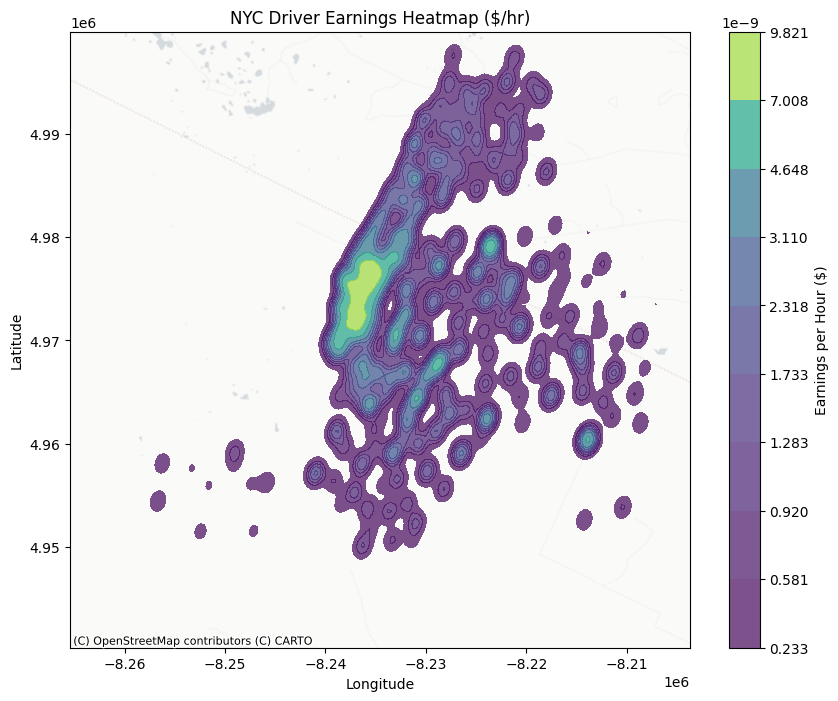

In [52]:
fig, ax = plt.subplots(figsize=(10, 8))
kde = sns.kdeplot(
    x=gdf.geometry.x, 
    y=gdf.geometry.y, 
    ax=ax, 
    fill=True, 
    cmap="viridis",
    alpha=0.7
)

# add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs)

# EPSG instead of actual long/lat
ax.set_title("NYC Driver Earnings Heatmap ($/hr)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# fix colorbar issue
fig.colorbar(ax.collections[-1], ax=ax, label="Earnings per Hour ($)")

plt.show()



In [53]:
# don't rewrite over final parquet, commented out on purpose

#df.to_parquet("final_model_data.parquet", engine="pyarrow")

In [54]:
# full feature modeling (minus temp and PU_Bronx)

cluster_features = [col for col in df.columns if col.startswith("cluster_")]

features = [
    
    "second_of_day",
    "day_of_year",
    "morning_rush",
    "evening rush",
    "temp",
    "holiday",
    "weekend",
    "airport",
    "congestion",
    "PUx",
    "PUy",
    "DOx",
    "DOy",
    "PU_Brooklyn",
    "PU_Manhattan",
    "PU_Queens",
    "PU_Staten Island",
    "service_1",
] + cluster_features


In [55]:
# train duration model with full features


df = df.dropna()

y = df["durationsec"] 
X = df[features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
y_pred_xgb = random_search.best_estimator_.predict(X_test)

xgb_duration = random_search.best_estimator_


Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [57]:
xgb_duration = random_search.best_estimator_

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.2f}")
r2_via_metric = r2_score(y_test, y_pred_xgb)
print("R² via r2_score:", r2_via_metric)

XGBoost MAE: 243.21
R² via r2_score: 0.789475264378392


In [58]:
# assess for feature selection

feature_importances = xgb_duration.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances.round(2)
})

importance_df

,Feature,Importance
0,second_of_day,0.01
1,day_of_year,0.00
2,morning_rush,0.00
3,evening rush,0.01
4,temp,0.00
5,holiday,0.00
6,weekend,0.01
7,airport,0.20
8,congestion,0.04
9,PUx,0.02


In [60]:
# refit model with features greater than 0.01

features2 = importance_df[importance_df["Importance"] > 0.01]["Feature"].tolist()
features2


['airport',
 'congestion',
 'PUx',
 'PUy',
 'DOx',
 'DOy',
 'PU_Brooklyn',
 'PU_Manhattan',
 'PU_Queens',
 'PU_Staten Island',
 'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8']

In [61]:
# train duration model with reduced features

y = df["durationsec"] 
X = df[features2]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

param_dist = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [9, 13, 15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
}

random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
y_pred_xgb = random_search.best_estimator_.predict(X_test)

xgb_duration = random_search.best_estimator_


xgb_duration = random_search.best_estimator_

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.2f}")
r2_via_metric = r2_score(y_test, y_pred_xgb)
print("R² via r2_score:", r2_via_metric)


KeyboardInterrupt: 

In [ ]:
# train duration model with original features from other notebook

features = ["second_of_day", "day_of_year", "PUx", "PUy", "DOx", "DOy", "distance", "morning_rush", "evening rush",
            "prcp", "temp", "holiday", "weekend", "airport", "congestion", "PU_Bronx", "PU_Brooklyn",
            "PU_Manhattan", "PU_Queens", "PU_Staten Island", "DO_Bronx", "DO_Brooklyn", 
            "DO_Manhattan", "DO_Queens", "DO_Staten Island"]

y = df["durationsec"] 
X = df[features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

param_dist = {
    'n_estimators': [300, 500],
    'learning_rate': [0.01, 0.02],
    'max_depth': [9, 13],
    'subsample': [0.8],
    'colsample_bytree': [0.4, 0.6],
}

random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
y_pred_xgb = random_search.best_estimator_.predict(X_test)

xgb_duration2 = random_search.best_estimator_


mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.2f}")
r2_via_metric = r2_score(y_test, y_pred_xgb)
print("R² via r2_score:", r2_via_metric)

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.6}
XGBoost MAE: 182.72
R² via r2_score: 0.8665667039969693


Best Duration Model of .86 R² and about three minutes off (mean absolute error)

In [ ]:
# train earnings model with full features

X = df[features]
y = df["profit_per_hour"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


In [ ]:

xgb_model = xgb.XGBRegressor(random_state=3)


params = {
    "n_estimators": [300, 500],
    "max_depth": [13, 15],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.4, 0.6]
}

random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=params,
        n_iter=10,  
        cv=3,  
        n_jobs=-1, 
        random_state=3
    )

random_search.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
xgb_model = random_search.best_estimator_

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R² score: {r2}")
print(f"Best parameters are: {random_search.best_params_}")
print(f"These predictions are off by about ${mae:.2f}")"


'\nfrom sklearn.metrics import r2_score\n\n\nxgb_model = random_search.best_estimator_\n\ny_pred = xgb_model.predict(X_test)\n\nmae = mean_absolute_error(y_test, y_pred)\nr2 = r2_score(y_test, y_pred)\nprint(f"R² score: {r2}")\nprint(f"Best parameters are: {random_search.best_params_}")\nprint(f"These predictions are off by about ${mae:.2f}")"\n'

In [ ]:
# dummy regressor for baseline #1

# Create a naive baseline model that always predicts the mean of y_train
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)

# Predict using the naive baseline model
y_pred_dummy = dummy_model.predict(X_test)

# Evaluate the naive model
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

# Evaluate the trained XGBoost model
y_pred_xgb = xgb_model.predict(X_test)  # Ensure you are using the best trained model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print comparison results
print(f"📊 Naive Baseline MAE: {mae_dummy:.2f}, R²: {r2_dummy:.4f}")
print(f"🚀 XGBoost Model MAE: {mae_xgb:.2f}, R²: {r2_xgb:.4f}")

# Determine if the model beats the baseline
if mae_xgb < mae_dummy:
    print("✅ The XGBoost model performs better than the naive baseline!")
else:
    print("❌ The XGBoost model does NOT outperform the naive baseline.")


NameError: name 'xgb_model' is not defined

In [ ]:
y_pred.mean()

80.562614

In [ ]:
# checking feature importances

feature_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances.round(2)
})

importance_df

NameError: name 'xgb_model' is not defined

In [ ]:
# refit model with features greater than 0.01

features2 = importance_df[importance_df["Importance"] > 0.01]["Feature"].tolist()
features2 = df[features2].drop(columns="distance")
features2.columns


NameError: name 'importance_df' is not defined

In [ ]:
# train the simpler model, zeroing in on params

# Prepare data
X = df[features2]
y = df["profit_per_hour"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

params = {
    "n_estimators": [800],
    "max_depth": [15],
    "learning_rate": [0.02],
    "subsample": [0.8],
    "colsample_bytree": [0.6],
    "reg_alpha": [0.05, 0.1] 
}

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=3)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=params,
    n_iter=8,  
    cv=3,  
    n_jobs=12, 
    random_state=3
)

random_search.fit(X_train, y_train)

# get best model
xgb_model = random_search.best_estimator_

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"R² score: {r2:.4f}")
print(f"Best parameters are: {random_search.best_params_}")
print(f"These predictions are off by about ${mae:.2f}")


ValueError: Found input variables with inconsistent numbers of samples: [21, 4090595]

In [ ]:
# whoops, so I won't save this model. distance left in - heavy leakage...

features2

['second_of_day',
 'day_of_year',
 'PUx',
 'PUy',
 'DOx',
 'DOy',
 'distance',
 'evening rush',
 'holiday',
 'weekend',
 'airport',
 'congestion',
 'PU_Bronx',
 'PU_Brooklyn',
 'PU_Manhattan',
 'PU_Queens',
 'PU_Staten Island',
 'DO_Bronx',
 'DO_Brooklyn',
 'DO_Manhattan',
 'DO_Queens',
 'DO_Staten Island']

In [ ]:
# don't save over best models unless intentional

"""
import pickle

with open("duration_model.pkl", "wb") as f:
    pickle.dump(xgb_duration2, f)

# Save the earnings per hour model
with open("earnings_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)
"""

'\nimport pickle\n\nwith open("duration_model.pkl", "wb") as f:\n    pickle.dump(xgb_duration2, f)\n\n# Save the earnings per hour model\nwith open("earnings_model.pkl", "wb") as f:\n    pickle.dump(xgb_model, f)\n'

So far best model performance is R² of .29 and MAE of $17.13

In [ ]:
# trying an MLP regressor

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    max_iter=100,
    early_stopping=True,
    verbose=True,
    random_state=3
)

nn_model.fit(X_train_scaled, y_train)
y_pred_nn = nn_model.predict(X_test_scaled)

mae_nn = mean_absolute_error(y_test, y_pred_nn)
print(f"🧠 Neural Network MAE (with Scaler): ${mae_nn:.2f}")


Iteration 1, loss = 414.57180535
Validation score: 0.242450
Iteration 2, loss = 353.51573835
Validation score: 0.260028
Iteration 3, loss = 349.56383858
Validation score: 0.265406
Iteration 4, loss = 347.91405189
Validation score: 0.268414
Iteration 5, loss = 346.86263983
Validation score: 0.271246
Iteration 6, loss = 346.03040180
Validation score: 0.268919
Iteration 7, loss = 345.34424920
Validation score: 0.274242
Iteration 8, loss = 344.70047975
Validation score: 0.274994
Iteration 9, loss = 344.19011594
Validation score: 0.276234
Iteration 10, loss = 343.69166201
Validation score: 0.277973
Iteration 11, loss = 343.38415701
Validation score: 0.276117
Iteration 12, loss = 343.10193141
Validation score: 0.276442
Iteration 13, loss = 342.84261016
Validation score: 0.278949
Iteration 14, loss = 342.54755866
Validation score: 0.277869
Iteration 15, loss = 342.33818575
Validation score: 0.280795
Iteration 16, loss = 342.07197063
Validation score: 0.280528
Iteration 17, loss = 341.84757416

In [ ]:
df[df["temp"] == df["temp"].max()]

,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,profit_per_hour,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,service_0,service_1,service_2
3280878,54005,198,0,0,0,0,0.0,93.92,-8.224175e+06,4.994236e+06,-8.224899e+06,4.989500e+06,3.74,891.0,23.28,0.00,0.0,0.00,23.28,1,0,0,0,0,1,0,0,0,0,93.120000,False,False,False,False,True,False,False,False,False,False,False,True
3280880,54008,198,0,0,0,0,0.0,93.92,-8.232025e+06,4.972525e+06,-8.232071e+06,4.977285e+06,3.43,890.0,20.51,0.00,0.0,0.00,20.51,0,1,0,0,0,0,0,1,0,0,82.040000,True,False,False,False,False,False,False,False,False,False,False,True
3280881,54008,198,0,0,0,0,0.0,93.92,-8.223575e+06,4.979119e+06,-8.229257e+06,4.973729e+06,4.98,1037.0,27.49,0.00,2.5,0.00,29.99,0,0,0,1,0,0,0,0,1,0,94.793103,False,False,False,False,False,True,False,False,False,False,False,True
3280882,54013,198,0,0,0,0,0.0,93.92,-8.251596e+06,4.955995e+06,-8.256665e+06,4.954465e+06,5.27,1107.0,26.81,0.00,0.0,0.00,26.81,0,0,0,0,1,0,0,0,0,1,86.483871,False,False,False,False,False,False,False,False,True,False,True,False
3280883,54016,198,0,0,0,0,0.0,93.92,-8.237192e+06,4.965138e+06,-8.223575e+06,4.979119e+06,11.49,3241.0,67.35,0.00,2.5,0.00,69.85,0,1,0,0,0,0,0,0,1,0,74.833333,False,False,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3281726,57533,198,0,0,0,0,0.0,93.92,-8.237008e+06,4.972977e+06,-8.235191e+06,4.961383e+06,13.12,2993.0,34.17,6.94,0.0,0.75,41.86,0,0,1,0,0,0,1,0,0,0,41.168675,True,False,False,False,False,False,False,False,False,False,True,False
3281727,57537,198,0,0,0,0,0.0,93.92,-8.213879e+06,4.960411e+06,-8.235026e+06,4.974131e+06,16.55,2713.0,73.92,6.93,2.5,2.75,86.10,0,0,0,1,0,0,0,1,0,0,98.560000,False,True,False,False,False,False,False,False,False,False,False,True
3281733,57568,198,0,0,0,0,0.0,93.92,-8.231603e+06,4.981417e+06,-8.257012e+06,4.966993e+06,20.27,4327.0,99.91,24.00,2.5,0.00,126.41,0,0,1,0,0,0,0,0,0,0,83.258333,False,False,False,False,False,True,False,False,False,False,False,True
3281737,57587,198,0,0,0,0,0.0,93.92,-8.222603e+06,4.992303e+06,-8.224175e+06,4.994236e+06,1.62,445.0,9.14,0.00,0.0,0.00,9.14,1,0,0,0,0,1,0,0,0,0,76.166667,False,False,False,False,True,False,False,False,False,False,True,False


In [ ]:
df

,second_of_day,day_of_year,weekend,holiday,morning_rush,evening rush,prcp,temp,PUx,PUy,DOx,DOy,distance,durationsec,fare,tolls,airport,congestion,total,PU_Bronx,PU_Brooklyn,PU_Manhattan,PU_Queens,PU_Staten Island,DO_Bronx,DO_Brooklyn,DO_Manhattan,DO_Queens,DO_Staten Island,profit_per_hour,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,service_0,service_1,service_2
1,9,1,0,1,0,0,0.0,42.80,-8.220657e+06,4.992372e+06,-8.218525e+06,4.993771e+06,2.47,785.0,14.59,0.0,0.0,0.0,14.59,1,0,0,0,0,1,0,0,0,0,66.318182,False,False,False,False,True,False,False,False,False,False,True,False
2,33,1,0,1,0,0,0.0,42.80,-8.231953e+06,4.974857e+06,-8.232025e+06,4.972525e+06,2.02,474.0,20.62,0.0,0.0,0.0,20.62,0,0,0,1,0,0,1,0,0,0,158.615385,False,False,False,False,False,False,True,False,False,False,False,True
3,38,1,0,1,0,0,0.0,42.80,-8.212420e+06,4.977409e+06,-8.216190e+06,4.976140e+06,2.47,459.0,23.20,0.0,0.0,0.0,23.20,0,0,0,1,0,0,0,0,1,0,178.461538,False,False,True,False,False,False,False,False,False,False,False,True
5,42,1,0,1,0,0,0.0,42.80,-8.223575e+06,4.979119e+06,-8.231792e+06,4.962136e+06,11.32,1883.0,89.42,0.0,2.5,0.0,91.92,0,0,0,1,0,0,1,0,0,0,171.961538,False,False,False,False,False,True,False,False,False,False,False,True
6,51,1,0,1,0,0,0.0,42.80,-8.239432e+06,4.969960e+06,-8.238897e+06,4.961199e+06,5.21,705.0,39.18,3.5,0.0,5.5,48.18,0,0,1,0,0,0,1,0,0,0,195.900000,True,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6044440,85839,366,0,0,0,0,0.0,48.02,-8.233297e+06,4.959078e+06,-8.233297e+06,4.959078e+06,0.41,197.0,7.75,0.0,0.0,0.0,7.75,0,1,0,0,0,0,1,0,0,0,155.000000,False,False,False,True,False,False,False,False,False,False,True,False
6044441,85841,366,0,0,0,0,0.0,48.02,-8.225994e+06,4.963283e+06,-8.223930e+06,4.962458e+06,1.52,444.0,9.91,0.0,0.0,0.0,9.91,0,1,0,0,0,0,1,0,0,0,82.583333,False,False,False,True,False,False,False,False,False,False,False,True
6044442,85846,366,0,0,0,0,0.0,48.02,-8.217649e+06,4.988984e+06,-8.221850e+06,4.985513e+06,2.48,534.0,14.38,0.0,0.0,0.0,14.38,1,0,0,0,0,1,0,0,0,0,95.866667,False,False,False,False,True,False,False,False,False,False,False,True
6044443,85864,366,0,0,0,0,0.0,48.02,-8.234034e+06,4.964909e+06,-8.231941e+06,4.963280e+06,1.58,488.0,15.01,0.0,0.0,0.0,15.01,0,1,0,0,0,0,1,0,0,0,107.214286,False,False,False,True,False,False,False,False,False,False,False,True
